In [1]:
#all imports here..
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline

from sklearn import metrics
from sklearn.metrics import auc, roc_auc_score, mutual_info_score, roc_curve

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
df = pd.read_csv('online_shoppers_intention.csv')

**EDA**

In [ ]:
df.shape

In [ ]:
df.head().T

formatting to lowercase columns' titles and values

In [3]:
df.columns = df.columns.str.replace(r'([a-z])([A-Z])', r'\1_\2', regex=True).str.lower()

In [4]:
strings = list(df.dtypes[df.dtypes == 'object'].index)
strings

['month', 'visitor_type']

In [5]:
for col in strings:
    df[col] = df[col].str.lower()

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
plt.figure()
df['revenue'].value_counts().plot(kind = 'bar')
plt.xlabel('gained revenue')
plt.ylabel('count')
plt.show()

<li>there are no missing values.</li>
<li>the target class ('revenue') is unbalanced distributed </li>
<li>administrative, informational and product_related are number of pages</li>

In [ ]:
plt.figure(figsize=(15,10))  
sns.heatmap(df.corr(),annot=True,linewidths=.5, cmap="Blues")
plt.title('Heatmap showing correlations between numerical data')
plt.show()

In [6]:
numeric_features = ['administrative', 'administrative_duration', 'informational',
       'informational_duration', 'product_related', 'product_related_duration',
       'bounce_rates', 'exit_rates', 'page_values', 'special_day',
                    'operating_systems', 'browser', 'region', 'traffic_type']

categorical_features = list(df.dtypes[df.dtypes == 'object'].index)

boolean_features = ['weekend']

len(numeric_features), len(categorical_features), len(boolean_features)

(14, 2, 1)

In [ ]:
#cox box analysis
g = sns.boxplot(data=df[numeric_features], orient="h")
g.set(xscale="log")  # log scale on x axes, otherwise figure dominated by product_related duration range
g

In [ ]:
df_clipped = df.copy()

df_clipped[numeric_features] = df[numeric_features].clip(df[numeric_features].quantile(0.10), 
                                                             df[numeric_features].quantile(0.90), axis=1)

#temp = df_clipped[numeric_features].drop(columns = ['product_related_duration'])

In [ ]:
#sns.boxplot(data=df_clipped[numeric_features], orient="h")
#sns.boxplot(data=temp, orient="h")


g = sns.boxplot(data=df_clipped[numeric_features], orient="h")
g.set(xscale="log")  # log scale on x axes, otherwise figure dominated by product_related duration range
g


In [7]:
target_name = 'revenue'  #True if session ended in a buy

data, target = df.drop(columns=target_name), df[target_name]
target = (target == True).astype(int)

data.shape, target.shape

((12330, 17), (12330,))

In [8]:
#in splitting, adopted stratify = <target column> , because of the unbalanced distribution

df_train, df_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=1,
                                         stratify = target)

In [9]:
df_train.shape, df_test.shape, y_train.shape, y_test.shape

((9864, 17), (2466, 17), (9864,), (2466,))

In [10]:
#ROC-AUC score for evaluation of feature importance (numeric features only)

feat_list = []

for c in numeric_features:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
#    print('%9s, %.3f' % (c, auc))
    feat_list.append((c, auc))

sorted(feat_list, key=lambda tup: tup[1], reverse=True)

[('page_values', 0.8619590722511253),
 ('exit_rates', 0.7034514407187545),
 ('product_related_duration', 0.6704164278750951),
 ('product_related', 0.6561536548707037),
 ('administrative', 0.6257758695759471),
 ('administrative_duration', 0.6240799516621938),
 ('bounce_rates', 0.6096819987884111),
 ('informational', 0.5657043719999107),
 ('informational_duration', 0.5625614007400941),
 ('special_day', 0.5385019775557404),
 ('operating_systems', 0.5204142429911597),
 ('region', 0.513045407546872),
 ('browser', 0.5066291579205815),
 ('traffic_type', 0.5017336425284672)]

In [11]:
#calculating mutual information to assess feature importance of categorical features

def calculate_mi(series):
    return mutual_info_score(series, y_train)

df_mi = df_train[categorical_features].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')
df_mi

,MI
month,0.015981
visitor_type,0.004480


first explorative classification with final features importance analysis

In [13]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[numeric_features + categorical_features + boolean_features].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

In [ ]:
X_train.shape

In [14]:
first_model = RandomForestClassifier()

scores = cross_val_score(first_model, X_train, y_train, scoring='roc_auc', cv=5, error_score='raise')

# mean scores and standard deviation
print('CV auc_roc: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV auc_roc: 0.924 +/- 0.004


In [15]:
first_model.fit(X_train, y_train)

RandomForestClassifier()

In [16]:
test_dict = df_test[numeric_features + categorical_features + boolean_features].to_dict(orient='records')
X_test = dv.transform(test_dict)

In [17]:
y_pred = first_model.predict(X_test)
y_pred_proba = first_model.predict_proba(X_test)[:,1]

In [18]:
y_pred.shape

(2466,)

In [19]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)

In [20]:
metrics.auc(fpr, tpr)

0.7683271196149168

In [21]:
#feature importances in random forest decision process (average impurity decrease)

importances = first_model.feature_importances_
#
# Sort the feature importance in descending order
#
sorted_indices = np.argsort(importances)[::-1]

feat_labels = dv.feature_names_
 
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[sorted_indices[f]],
                            importances[sorted_indices[f]]))

 1) page_values                    0.357792
 2) product_related_duration       0.089983
 3) exit_rates                     0.088709
 4) product_related                0.072182
 5) administrative_duration        0.057037
 6) bounce_rates                   0.053423
 7) administrative                 0.043908
 8) traffic_type                   0.031676
 9) region                         0.031513
10) informational_duration         0.026767
11) month=nov                      0.023131
12) browser                        0.020442
13) informational                  0.019194
14) operating_systems              0.018497
15) weekend                        0.010233
16) visitor_type=returning_visitor 0.008203
17) visitor_type=new_visitor       0.007797
18) month=may                      0.007102
19) month=dec                      0.005689
20) month=mar                      0.004901
21) month=sep                      0.004316
22) month=oct                      0.004081
23) special_day                 

In [22]:
### DA RIMUOVERE  


#df = df_clipped
df_simpl = df.drop(['administrative', 'administrative_duration', 'month','browser','operating_systems',
                    'region','traffic_type','weekend', 'special_day', 'visitor_type', 'informational', 
                    'informational_duration'], axis=1)

categorical_features = []
numeric_features = ['product_related', 'product_related_duration',
       'bounce_rates', 'exit_rates', 'page_values']
boolean_features = []

In [23]:
target_name = 'revenue'  #True if session ended in a buy

data, target = df_simpl.drop(columns=target_name), df_simpl[target_name]
target = (target == True).astype(int)

data.shape, target.shape

((12330, 5), (12330,))

In [24]:
#in splitting, adopted stratify = <target column> , because of the unbalanced distribution

df_train, df_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=1,
                                         stratify = target)

In [25]:
df_train.shape, df_test.shape, y_train.shape, y_test.shape

((9864, 5), (2466, 5), (9864,), (2466,))

In [26]:
df_train.head().T

,7349,8611,3877,2625,3508
product_related,67.000000,4.000000,12.000000,31.000000,14.000000
product_related_duration,1207.653333,67.250000,590.833333,1239.083333,1539.000000
bounce_rates,0.020833,0.000000,0.010000,0.006667,0.015385
exit_rates,0.047826,0.013333,0.030000,0.020000,0.030769
page_values,0.000000,0.000000,0.000000,0.000000,0.000000


**Estimating generalization error via nested cross validation.**

Note that nested cross-val is time consuming and it is suited for small datasets like ours that is under 10000 rows

First model is LogisticRegression()

In [ ]:
model_lr = LogisticRegression(max_iter = 10_000)


'''
pipe_lr = Pipeline([
    ('vectorizer', DictVectorizer(sparse = False)),
    ('clf_lr', LogisticRegression(max_iter = 10_000))
])
'''

In [ ]:
'''
param_grid = {
    'clf_lr__C': [0.001, 0.01, 0.1, 0.5, 1, 5, 10]}
'''

param_grid = {
    'C': [0.001, 0.01, 0.1, 0.5, 1, 5, 10]}

In [ ]:
# Making a Grid Search for selecting model by hyperparameter tuning, using
# 2-fold StratifiedKFold cross validation

gs = GridSearchCV(estimator= model_lr, param_grid = param_grid,
                 cv = 2, scoring = 'roc_auc')

In [ ]:
#(nested) cross validation ( 5 x 2 cross-val: inner = 2 folds, outer = 5 folds). Inner is in the cell above..
#No need of separatation in train and val, in view of the use of cross-validation

scores = cross_val_score(gs, df_train, y_train, scoring='roc_auc', cv=5, error_score='raise')

# mean scores and standard deviation
print('CV auc_roc: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Second model is RandomForestClassifier()

In [ ]:
model_rf = RandomForestClassifier()

'''
pipe_rf = Pipeline([
    ('vectorizer', DictVectorizer(sparse = False)),
    ('clf_rf', RandomForestClassifier())
])
'''

In [ ]:
'''
param_grid = {
    'clf_rf__max_depth': [5, 10, 15, 20],
    'clf_rf__n_estimators' : [100, 200, 500],
    'clf_rf__min_samples_leaf': [3, 5, 10]}
'''

param_grid = {
    'max_depth': [5, 10, 15, 20],
    'n_estimators' : [100, 200, 500],
    'min_samples_leaf': [3, 5, 10]}

In [ ]:
gs = GridSearchCV(estimator = model_rf, param_grid = param_grid,
                 cv = 2, scoring = 'roc_auc')

In [ ]:
scores = cross_val_score(gs, df_train, y_train, scoring='roc_auc', cv=5, error_score='raise')

print('CV auc_roc: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

**Selecting the final model to use in deployment**

after having calculated a robust estimate of the generalization errors of the models, we continue with the better one (RandomForestClassifier), to find his optimal hyperparameters values by means of gridSearchCV, then we will define the best model to adopt for the deployment part

In [ ]:
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'n_estimators' : [100, 200, 500],
    'min_samples_leaf': [3, 5, 10]}

In [ ]:
gs2 = GridSearchCV(estimator=RandomForestClassifier(random_state=1), param_grid = param_grid,
                 cv = 5, scoring = 'roc_auc')

In [ ]:
gs2.fit(df_train, y_train)

In [ ]:
gs2.best_params_

**Final model**

In [27]:
final_model = RandomForestClassifier(max_depth = 5, 
                                     n_estimators = 1000, random_state = 1)

In [28]:
final_model.fit(df_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=1000, random_state=1)

In [29]:
final_model.classes_

array([0, 1])

In [ ]:
test_dict = df_test[numeric_features + categorical_features + boolean_features].to_dict(orient='records')
X_test = dv.transform(test_dict)

In [30]:
y_pred = final_model.predict(df_test)
y_pred_proba = final_model.predict_proba(df_test)[:,1]

In [31]:
y_pred.shape

(2466,)

In [32]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)

In [33]:
metrics.auc(fpr, tpr)

0.7614120549486992

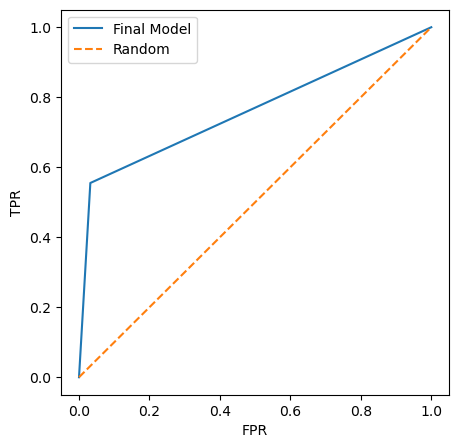

In [34]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Final Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

## Bento ML

In [ ]:
import bentoml

In [ ]:
bentoml.sklearn.save_model(
    'shopper_intention',
    final_model,
    custom_objects={
        'dictVectorizer': dv
    },
    signatures = {
        'predict_proba':{
                'batchable': True,
                'batch_dim': 0
        }        
    }
    )

**Create Test input**

In [ ]:
test_dict = df_test[numeric_features + categorical_features + boolean_features].to_dict(orient='records')
X_test = dv.transform(test_dict)

In [ ]:
X_test.shape

In [ ]:
import json

In [ ]:
request = df_test.iloc[0].to_dict()
print(json.dumps(request, indent=2))

In [ ]:
print(y_test[0])

In [ ]:
final_model.predict_proba([X_test[0,:]])
#y_pred_proba[0]

In [ ]:
#df.index[df['revenue'] == True].tolist()[0]
y_test

In [ ]:
request = df_test.iloc[65].to_dict()
print(json.dumps(request, indent=2))

In [ ]:
print(y_test[65])

In [ ]:
final_model.predict_proba([X_test[65,:]])